# Load Necessary Libraries 

In [37]:
#
#    IMPORTS
# 

#    Import some standard python modules
import os, json, time
#
#    The module pyproj is a standard module that can be installed using pip or your other favorite
#    installation tool. This module provides tools to convert between different geodesic coordinate systems
#    and for calculating distances between points (coordinates) in a specific geodesic system.
#
from pyproj import Transformer, Geod
#
#    The 'wildfire' module is a user module. This module is available from the course website. The module
#    includes one object, a Reader, that can be used to read the GeoJSON files associated with the
#    wildefire dataset. The module also contains a sample datafile that is GeoJSON compliant and that
#    contains a small number of wildfires extracted from the main wildfire dataset.
#    
from wildfire.Reader import Reader as WFReader
#
#    There is a GeoJSON reader that you might try if you wanted to read the data. It has its own quirks.
#    There will be an example below that reads the sample file "Wildfire_short_sample.json"
#    
import geojson


In [183]:
# following libraries are used for predictive models and visualization later throughout the notebook
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression
import numpy as np

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import warnings
import statsmodels.api as sm


# Data Processing

I used the example code provided by Dr. David McDonald in `wildfire_geo_proximity_example.ipynb`, particularly example #2 to load in the wildfire json data by batches 

In [ ]:
# city specification dictionary 
CITY_LOCATIONS = {
    'dayton' :       {'city'   : 'Dayton',
                       'county' : 'Montgomery',
                       'state'  : 'Ohio',
                       'fips'   : '39113',
                       'latlon' : [39.759444, -84.191667] }} 


In [40]:
# wildfire data reader from given files
from wildfire.Reader import Reader as WFReader

#filepath to get data from
DATA_FILENAME = './GeoJSON Exports/USGS_Wildland_Fire_Combined_Dataset.json'

#initalize reader object
reader = WFReader()

# check file exists
try:
    print(f"attempting to open '{DATA_FILENAME}'")
    reader.open(DATA_FILENAME)
    print(f"File '{DATA_FILENAME}' opened successfully")
except Exception as e:
    print(f"Failed to open file: {str(e)}")
    raise

# initalize empty list to store json objects to
batch = []
count = 0

while True:
    try:

        # get next feature
        feature = reader.next()

        # if feature exists 
        if feature:
            batch.append(feature)
            count += 1

        # reached end of file 
        else:
            break

    except Exception as e:
        print(f"Error reading feature {str(e)}")
        break

if len(batch) > 0:
    print(f"processing final batch of {len(batch)} features...")

reader.close()

# display number of features (wildfires) read 
print(f"Finishing reading {count} features from the file")


attempting to open './GeoJSON Exports/USGS_Wildland_Fire_Combined_Dataset.json'
File './GeoJSON Exports/USGS_Wildland_Fire_Combined_Dataset.json' opened successfully
processing final batch of 135061 features...
Finishing reading 135061 features from the file


## Geodetic Distance Computations

I used functions from the `wildfire_geo_proximity_example.ipynb` notebook to calculate the geodetic distance between my city and wildfires within the US meeting the time criteria. 

In [5]:
#
#    Transform feature geometry data
#
#    The function takes one parameter, a list of ESRI:102008 coordinates that will be transformed to EPSG:4326
#    The function returns a list of coordinates in EPSG:4326
def convert_ring_to_epsg4326(ring_data=None):
    converted_ring = list()
    #
    # We use a pyproj transformer that converts from ESRI:102008 to EPSG:4326 to transform the list of coordinates
    to_epsg4326 = Transformer.from_crs("ESRI:102008","EPSG:4326")
    # We'll run through the list transforming each ESRI:102008 x,y coordinate into a decimal degree lat,lon
    for coord in ring_data:
        lat,lon = to_epsg4326.transform(coord[0],coord[1])
        new_coord = lat,lon
        converted_ring.append(new_coord)
    return converted_ring

In [41]:
#    
#    The function takes two parameters
#        A place - which is coordinate point (list or tuple with two items, (lat,lon) in decimal degrees EPSG:4326
#        Ring_data - a list of decimal degree coordinates for the fire boundary
#
#    The function returns a list containing the shortest distance to the perimeter and the point where that is
#
def shortest_distance_from_place_to_fire_perimeter(place=None,ring_data=None):
    # convert the ring data to the right coordinate system
    ring = convert_ring_to_epsg4326(ring_data)    
    # create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps='WGS84')
    closest_point = list()
    # run through each point in the converted ring data
    for point in ring:
        # calculate the distance
        d = geodcalc.inv(place[1],place[0],point[1],point[0])
        # convert the distance to miles
        distance_in_miles = d[2]*0.00062137
        # if it's closer to the city than the point we have, save it
        if not closest_point:
            closest_point.append(distance_in_miles)
            closest_point.append(point)
        elif closest_point and closest_point[0]>distance_in_miles:
            closest_point = list()
            closest_point.append(distance_in_miles)
            closest_point.append(point)
    return closest_point

The `filter_wildfire_data` function below takes in the loaded wildfire json file and filters out any wildfires that did not occur within wildfire season (May 1 - Oct 31), and those that did not occuur within (1961 to 2021) and that are not within 1800 miles of Dayton, Ohio. I filtered this fitlered batch to get a separate set of fires within 650 miles of Dayton, as this is the threshold used for predictive modeling and some graphs. 

In [ ]:
from datetime import datetime
import re

def filter_wildfire_data(batch, city_coordinates):
    '''
    batch: the wildfire json data
    city_coordinates: latitude and longitude of Dayton, Ohio
    '''

    #initalize list store filtered wildfire data
    filtered_batch = []
    
    # iterate through batches 
    for feature in batch:

        # get attribute dict
        attributes = feature.get('attributes', {})

        # get the year and the fire dates
        fire_year = attributes.get('Fire_Year')
        fire_dates = attributes.get('Listed_Fire_Dates', '')

        # if fire dates exist 
        if fire_dates: 
            match = re.search(r'\d{4}-\d{2}-\d{2}', fire_dates)
            if match:
                fire_dates = match.group(0)  # Return the matched date
        else:
            fire_dates = None
        
        # to get ring data 
        if 'geometry' not in feature.keys():
            print("no geometry key")
            continue
        elif 'rings' not in feature['geometry'].keys():
            print("no rings key")
            continue
        else:
            ring_data = feature['geometry']['rings'][0]


        
        # if the fire year is within the last 60 years
        if (fire_year >= 1961) and (fire_year <= 2021):
            
            # check there are fire dates 
            if fire_dates:  

                # get all fire dates 
                fire_date_parts = fire_dates.split(':')[-1].strip().split(' - ')
                for date_str in fire_date_parts:
                    
                    try:
                        # Convert date strings to datetime objects
                        fire_date = datetime.strptime(date_str, "%Y-%m-%d")

                        # check if fire date within may 1 and oct 31
                        start_date = datetime(fire_date.year, 5, 1)  
                        end_date = datetime(fire_date.year, 10, 31) 

                        if start_date <= fire_date <= end_date:

                            # check there is ring data
                            if ring_data:  
                                distance_info = shortest_distance_from_place_to_fire_perimeter(city_coordinates, ring_data)
                                
                                # Check if within 1800 miles
                                if distance_info and distance_info[0] <= 1800:  
                                    feature['distance'] = distance_info[0]
                                    filtered_batch.append(feature)
                                    
                    except ValueError:

                        # skip incorrect date format 
                        print("date format unrecognized")
                        continue

    return filtered_batch

latitude = CITY_LOCATIONS['dayton']['latlon'][0]
longitude = CITY_LOCATIONS['dayton']['latlon'][1]

# define tuple of city coordinates
city_coordinates = (latitude, longitude)  

# call function to get filtered batch
filtered_batch = filter_wildfire_data(batch, city_coordinates)

print(f"Filtered {len(filtered_batch)} features that meet the criteria.")

There are 40,853 wildfires within 1800 miles of Dayton, Ohio

In [290]:
len(filtered_batch)

40853

Then I filtered my existing fitlered dataframe to now include wildfires only within 650 miles of Dayton, Ohio. As this data is used for the rest of the analysis

In [43]:
# intialize empty list to store data
filtered_batch_650 = []

# iterate through fires 
for feature in filtered_batch:

    #check fires are within 650 miles 
    if (feature['distance']) and (feature['distance'] <= 650):
        filtered_batch_650.append(feature)

For the fires within 650 miles, I calculates the smoke estimate using the following equation: *GIS_Acres / (distance)^2*. I calculated the smoke estimate for each fire and then added the estimates for a given year to get each year's final smoke estimate. 

In [219]:
# intialize empty dictionary to store year and estimate
estimate = {}

# iterate through wildfires 
for feature in filtered_batch_650:

    # calcualte estimate 
    est = feature['attributes']['GIS_Acres'] / (feature['distance']**2)

    # if we have seen year already 
    if feature['attributes']['Fire_Year'] in estimate:

        # add estimate to existing year estimate
        estimate[feature['attributes']['Fire_Year']] += est 
    else:
        estimate[feature['attributes']['Fire_Year']] = est 


I saves the filtered_batch (within 1800 miles) to a json file as reading it in might be faster than having to run the code to filter the original wildfire data. 

In [63]:
# write filtered data (within 1800 miles to json file)
with open('filtered_batch.json', 'w') as json_file:
    json.dump(filtered_batch, json_file, indent=4)  


In [59]:
# read in json file 
with open('filtered_batch.json', 'r') as json_file:
    filtered_data = json.load(json_file)

I used code below from the `epa_air_quality_history_example.ipynb` to set up the API request template and make the necessary calls to access the AQI data. 

In [48]:
#import json, time, urllib.parse
import json, time
#
#    The 'requests' module is a distribution module for making web requests. If you do not have it already, you'll need to install it
import requests

In [49]:
#########
#
#    CONSTANTS
#

#
#    This is the root of all AQS API URLs
#
API_REQUEST_URL = 'https://aqs.epa.gov/data/api'

#
#    These are some of the 'actions' we can ask the API to take or requests that we can make of the API
#
#    Sign-up request - generally only performed once - unless you lose your key
API_ACTION_SIGNUP = '/signup?email={email}'
#
#    List actions provide information on API parameter values that are required by some other actions/requests
API_ACTION_LIST_CLASSES = '/list/classes?email={email}&key={key}'
API_ACTION_LIST_PARAMS = '/list/parametersByClass?email={email}&key={key}&pc={pclass}'
API_ACTION_LIST_SITES = '/list/sitesByCounty?email={email}&key={key}&state={state}&county={county}'
#
#    Monitor actions are requests for monitoring stations that meet specific criteria
API_ACTION_MONITORS_COUNTY = '/monitors/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_MONITORS_BOX = '/monitors/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    Summary actions are requests for summary data. These are for daily summaries
API_ACTION_DAILY_SUMMARY_COUNTY = '/dailyData/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_DAILY_SUMMARY_BOX = '/dailyData/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    It is always nice to be respectful of a free data resource.
#    We're going to observe a 100 requests per minute limit - which is fairly nice
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED
#
#
#    This is a template that covers most of the parameters for the actions we might take, from the set of actions
#    above. In the examples below, most of the time parameters can either be supplied as individual values to a
#    function - or they can be set in a copy of the template and passed in with the template.
# 
AQS_REQUEST_TEMPLATE = {
    "email":      "",     
    "key":        "",      
    "state":      "",     # the two digit state FIPS # as a string
    "county":     "",     # the three digit county FIPS # as a string
    "begin_date": "",     # the start of a time window in YYYYMMDD format
    "end_date":   "",     # the end of a time window in YYYYMMDD format, begin_date and end_date must be in the same year
    "minlat":    0.0,
    "maxlat":    0.0,
    "minlon":    0.0,
    "maxlon":    0.0,
    "param":     "",     # a list of comma separated 5 digit codes, max 5 codes requested
    "pclass":    ""      # parameter class is only used by the List calls
}



In [50]:
#
#    This implements the sign-up request. The parameters are standardized so that this function definition matches
#    all of the others. However, the easiest way to call this is to simply call this function with your preferred
#    email address.
#
def request_signup(email_address = None,
                   endpoint_url = API_REQUEST_URL, 
                   endpoint_action = API_ACTION_SIGNUP, 
                   request_template = AQS_REQUEST_TEMPLATE,
                   headers = None):
    
    # Make sure we have a string - if you don't have access to this email addres, things might go badly for you
    if email_address:
        request_template['email'] = email_address        
    
    if not request_template['email']: 
        raise Exception("Must supply an email address to call 'request_signup()'")

    if '@' not in request_template['email']: 
        raise Exception(f"Must supply an email address to call 'request_signup()'. The string '{request_template['email']}' does not look like an email address.")

    # Compose the signup url - create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

In [69]:
#print("Requesting SIGNUP ...")
#USERNAME = "igokhale101@gmail.com"
#response = request_signup(USERNAME)
#print(json.dumps(response,indent=4))

Requesting SIGNUP ...
{
    "Header": [
        {
            "status": "Success",
            "request_time": "2024-10-28T16:30:00-04:00",
            "url": "https://aqs.epa.gov/data/api/signup?email=igokhale101@gmail.com"
        }
    ],
    "Data": [
        "You should receive a registration confirmation email with a link for confirming your email shortly."
    ]
}


In [52]:
#    This implements the list request. There are several versions of the list request that only require email and key.
#    This code sets the default action/requests to list the groups or parameter class descriptors. Having those descriptors 
#    allows one to request the individual (proprietary) 5 digit codes for individual air quality measures by using the
#    param request. Some code in later cells will illustrate those requests.
#
def request_list_info(email_address = None, key = None,
                      endpoint_url = API_REQUEST_URL, 
                      endpoint_action = API_ACTION_LIST_CLASSES, 
                      request_template = AQS_REQUEST_TEMPLATE,
                      headers = None):
    
    #  Make sure we have email and key - at least
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    
    # For the basic request we need an email address and a key
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_list_info()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_list_info()'")

    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

Below I test out the `request_list_info` function call to see how it works. 

In [53]:
#   The default should get us a list of the various groups or classes of sensors. These classes are user defined names for clustors of
#   sensors that might be part of a package or default air quality sensing station. We need a class name to start getting down to the
#   a sensor ID. Each sensor type has an ID number. We'll eventually need those ID numbers to be able to request values that come from
#   that specific sensor.
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY

response = request_list_info(request_template=request_data)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))

[
    {
        "code": "AIRNOW MAPS",
        "value_represented": "The parameters represented on AirNow maps (88101, 88502, and 44201)"
    },
    {
        "code": "ALL",
        "value_represented": "Select all Parameters Available"
    },
    {
        "code": "AQI POLLUTANTS",
        "value_represented": "Pollutants that have an AQI Defined"
    },
    {
        "code": "CORE_HAPS",
        "value_represented": "Urban Air Toxic Pollutants"
    },
    {
        "code": "CRITERIA",
        "value_represented": "Criteria Pollutants"
    },
    {
        "code": "CSN DART",
        "value_represented": "List of CSN speciation parameters to populate the STI DART tool"
    },
    {
        "code": "FORECAST",
        "value_represented": "Parameters routinely extracted by AirNow (STI)"
    },
    {
        "code": "HAPS",
        "value_represented": "Hazardous Air Pollutants"
    },
    {
        "code": "IMPROVE CARBON",
        "value_represented": "IMPROVE Carbon Parameters"
    }

In [54]:
AQI_PARAM_CLASS = "AQI POLLUTANTS"
#   Structure a request to get the sensor IDs associated with the AQI
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['pclass'] = AQI_PARAM_CLASS  # here we specify that we want this 'pclass' or parameter classs

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_PARAMS)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))

[
    {
        "code": "42101",
        "value_represented": "Carbon monoxide"
    },
    {
        "code": "42401",
        "value_represented": "Sulfur dioxide"
    },
    {
        "code": "42602",
        "value_represented": "Nitrogen dioxide (NO2)"
    },
    {
        "code": "44201",
        "value_represented": "Ozone"
    },
    {
        "code": "81102",
        "value_represented": "PM10 Total 0-10um STP"
    },
    {
        "code": "88101",
        "value_represented": "PM2.5 - Local Conditions"
    },
    {
        "code": "88502",
        "value_represented": "Acceptable PM2.5 AQI & Speciation Mass"
    }
]


In [55]:
#
#   Gaseous AQI pollutants CO, SO2, NO2, and O2
AQI_PARAMS_GASEOUS = "42101,42401,42602,44201"
#
#   Particulate AQI pollutants PM10, PM2.5, and Acceptable PM2.5
AQI_PARAMS_PARTICULATES = "81102,88101,88502"

Finally, I set my city fips code into the reqest data dictionary and see the monitoring stations in my county.

In [57]:
#  This list request should give us a list of all the monitoring stations in the county specified by the
#  given city selected from the CITY_LOCATIONS dictionary
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['state'] = CITY_LOCATIONS['dayton']['fips'][:2]   # the first two digits (characters) of FIPS is the state code
request_data['county'] = CITY_LOCATIONS['dayton']['fips'][2:]  # the last three digits (characters) of FIPS is the county code

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_SITES)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))

[
    {
        "code": "0001",
        "value_represented": null
    },
    {
        "code": "0002",
        "value_represented": null
    },
    {
        "code": "0003",
        "value_represented": null
    },
    {
        "code": "0004",
        "value_represented": null
    },
    {
        "code": "0005",
        "value_represented": null
    },
    {
        "code": "0006",
        "value_represented": null
    },
    {
        "code": "0007",
        "value_represented": null
    },
    {
        "code": "0008",
        "value_represented": null
    },
    {
        "code": "0014",
        "value_represented": null
    },
    {
        "code": "0015",
        "value_represented": null
    },
    {
        "code": "0016",
        "value_represented": null
    },
    {
        "code": "0017",
        "value_represented": null
    },
    {
        "code": "0018",
        "value_represented": null
    },
    {
        "code": "0019",
        "value_represented": null
    },
    

Below I check the non null values to determe the existing monitoring stations: I have a total of 7 monitoring stations. 

In [58]:
# list comprehension to filter our nulls 
stations = [key for key in response['Data'] if key['value_represented'] != None]

#display
stations

[{'code': '0028', 'value_represented': 'FROC'},
 {'code': '0031', 'value_represented': 'ROOF OF WILBUR WRIGHT SCHOOL'},
 {'code': '0032', 'value_represented': 'LIBRARY (DAYTON PUBLIC'},
 {'code': '0034', 'value_represented': 'Reibold'},
 {'code': '0037', 'value_represented': 'Eastwood'},
 {'code': '0038', 'value_represented': 'Sinclair'},
 {'code': '7001', 'value_represented': 'Moraine Fire St28'}]

Now I use the `request_daily_summary` function to get pollutant data from my 8 existing monitoring stations. 

In [59]:
#
#    This implements the daily summary request. Daily summary provides a daily summary value for each sensor being requested
#    from the start date to the end date. 
#
#    Like the two other functions, this can be called with a mixture of a defined parameter dictionary, or with function
#    parameters. If function parameters are provided, those take precedence over any parameters from the request template.
#
def request_daily_summary(email_address = None, key = None, param=None,
                          begin_date = None, end_date = None, fips = None,
                          endpoint_url = API_REQUEST_URL, 
                          endpoint_action = API_ACTION_DAILY_SUMMARY_COUNTY, 
                          request_template = AQS_REQUEST_TEMPLATE,
                          headers = None):
    
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    if param:
        request_template['param'] = param
    if begin_date:
        request_template['begin_date'] = begin_date
    if end_date:
        request_template['end_date'] = end_date
    if fips and len(fips)==5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[2:]            

    # Make sure there are values that allow us to make a call - these are always required
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_daily_summary()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_daily_summary()'")
    if not request_template['param']: 
        raise Exception("Must supply param values to call 'request_daily_summary()'")
    if not request_template['begin_date']: 
        raise Exception("Must supply a begin_date to call 'request_daily_summary()'")
    if not request_template['end_date']: 
        raise Exception("Must supply an end_date to call 'request_daily_summary()'")
    # Note we're not validating FIPS fields because not all of the daily summary actions require the FIPS numbers
        
    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


I iterate from 1961 to 2021 and request_daily_summary for those years during wildfire season. I make two separate calls per year to `request_daily_summary`: one for gaseous pollutants, and one for particulate pollutants. 

In [60]:

request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['state'] = CITY_LOCATIONS['dayton']['fips'][:2]
request_data['county'] = CITY_LOCATIONS['dayton']['fips'][2:]

#initalize empty lists to pollutant data
gaseous_aqi = []
particulate_aqi = []

# loop through each year from 1961 to 2021
for year in range(1961, 2022):

    # start and end dates for the fire season
    begin_date = f"{year}0501"  # May 1st of the current year
    end_date = f"{year}1031"     # October 31st of the current year
    
    # function call for gaseous pollutants 
    request_data['param'] = AQI_PARAMS_GASEOUS
    year_gaseous_aqi = request_daily_summary(request_template=request_data, begin_date=begin_date, end_date=end_date)

    # function call for partiuclate pollutants 
    request_data['param'] = AQI_PARAMS_PARTICULATES
    year_particulate_aqi = request_daily_summary(request_template=request_data, begin_date=begin_date, end_date=end_date)

    # append to respective list 
    gaseous_aqi.append(year_gaseous_aqi)
    particulate_aqi.append(year_particulate_aqi)


Below I find how many actual aqi values I have for each pollutant type (gaseous and particulate). I had 59 years worth of data for particulate pollutants but only 37 for the gaseous pollutants. Thus, I decided to use the AQI value from the particulate pollutants only. 

In [309]:
# list comprehension to check non null values for AQI pollutants 
not_empty = [item for item in particulate_aqi if len(item['Data']) > 0]
print("gaseous", len(not_empty))

not_empty_gas = [item for item in gaseous_aqi if len(item['Data']) > 0]
print("particulate", len(not_empty_gas))


gaseous 37
particulate 59


## Gathering Data for Graphs and Predictive Model 

Then I added the AQI values from the particulate data dictionaries for the available years into a list. I also made a list of the year at which it was gathered. Due to the fact that I had limited data, I did not multiple AQI values for a given year. I also double check that the date the value was determined was within wildfire season. 

In [315]:
# intialize empty lists to store year and AQI value for that year 
part_aqi = []
year_aqi  = []

# iterate through aqi dictionaries to extract aqi value
for item in particulate_aqi:

    # elements exist in the list 
    if len(item['Data']) > 0:

        # aqi key exists 
        if ('aqi' in list(item['Data'][0].keys())):

            #convert to datetime
            date = datetime.strptime(item['Data'][0]['date_local'], "%Y-%m-%d")
            
            year = date.year

            #check AQI val was gathered during wildfire season
            start_date = datetime(year, 5, 1)
            end_date = datetime(year, 10, 31)

            # add to lists 
            if start_date <= date <= end_date:
                part_aqi.append(item['Data'][0]['aqi'])
                year_aqi.append(item['Data'][0]['date_local'].split('-')[0])

                

Then, I put these two lists into a dataframe so that it is easier to plot. I also use the estimate dictionary from earlier and convert it to a dataframe. Lastly I add a column to each dataframe with scaled AQI and scaled smoke estimate for a future plot. 

In [341]:
# put lists into dataframe
df = pd.DataFrame({
    'AQI': part_aqi,
    'Year': year_aqi
})

# convert dict to dataframe 
df_estimate = pd.DataFrame(list(estimate.items()), columns=['Year', 'Estimate'])

# drop outlier for predictive model
df_estimate = df_estimate.drop(27)

# scale AQI and smoke estimate for future graph 
df['AQI_scaled'] = (df['AQI'] - df['AQI'].min()) / (df['AQI'].max() - df['AQI'].min())
df_estimate['estimate_scaled'] = (df_estimate['Estimate'] - df_estimate['Estimate'].min()) / (df_estimate['Estimate'].max() - df_estimate['Estimate'].min())


# Predictive Model

I used an ARIMA time series model to get my future predictions with my explanatory variable as the smoke estimate from 1961 to 2021. I wanted to keep my model simple and interpretiable which is why I used just one variable. Also, my smoke estimate is a function of Acres burned and distance from fire so it encapsulates multiple inportant variables. I added some random noise to my model due to the fact that randomness exists in the real world. Also, I checked that my data met the assumption of stationatity through the Augmented Dickey-Fuller test, and the p value was below 0.05 confirming that my yearly smoke estimate data is stationary. I also removed an outlier from my data so that it would not skew my predictions. Also if a Confidence interval bound is below 0, I set it to 0. 

ADF Statistic: -3.7566832081455814
p-value: 0.0033829297425266016


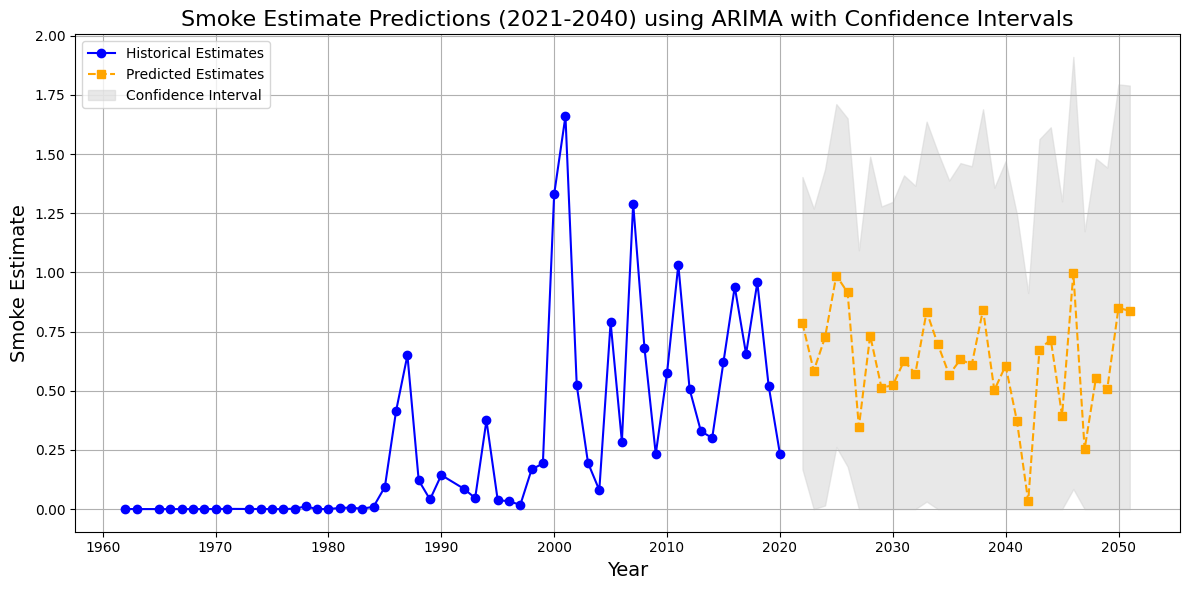

,Year,Estimate,estimate_scaled,Predicted Estimate,Lower Bound,Upper Bound,A
0,1962-01-01,0.000413,0.000247,NaN,NaN,NaN,NaN
1,1963-01-01,0.000217,0.000129,NaN,NaN,NaN,NaN
2,1965-01-01,0.000082,0.000048,NaN,NaN,NaN,NaN
3,1966-01-01,0.000003,0.000000,NaN,NaN,NaN,NaN
4,1967-01-01,0.000128,0.000075,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
81,2046-12-31,NaN,NaN,0.252768,0.0,1.173623,0.252768
82,2047-12-31,NaN,NaN,0.552793,0.0,1.481516,0.552793
83,2048-12-31,NaN,NaN,0.506205,0.0,1.442730,0.506205
84,2049-12-31,NaN,NaN,0.850197,0.0,1.794461,0.850197


In [333]:
# suppress warnings
warnings.simplefilter(action='ignore')

# year column to datetime format
df_estimate['Year'] = pd.to_datetime(df_estimate['Year'], format='%Y')

# year is index 
df_estimate = df_estimate.set_index('Year')

# check for stationarity using the Augmented Dickey-Fuller test
result = adfuller(df_estimate['Estimate'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# fit arima model 
model = ARIMA(df_estimate['Estimate'], order=(1, 1, 1))
model_fit = model.fit()

# Forecast for the next 20 years
forecast = model_fit.get_forecast(steps=30)
predicted_mean = forecast.predicted_mean


predictions = predicted_mean 

# add some noise to the predictions
np.random.seed(0)  
predictions += np.random.normal(0, 0.2, size= predictions.shape)  # adjust the noise level

confidence_intervals = forecast.conf_int()

# Create a DataFrame for predictions
future_years = pd.date_range(start='2021', periods=30, freq='Y')
pred_df = pd.DataFrame({
    'Year': future_years,
    'Predicted Estimate': predictions,
    'Lower Bound': confidence_intervals.iloc[:, 0], #* 1.5,  # Scale lower bound
    'Upper Bound': confidence_intervals.iloc[:, 1] #* 1.5   # Scale upper bound
})

pred_df['A'] = pred_df['Predicted Estimate'].where(pred_df['Predicted Estimate'] >= 0, 0)
pred_df['Lower Bound'] = pred_df['Lower Bound'].where(pred_df['Lower Bound'] >= 0, 0)
pred_df['Upper Bound'] = pred_df['Upper Bound'].where(pred_df['Upper Bound'] >= 0, 0)



# combine historical data with preds
combined_df = pd.concat([df_estimate.reset_index(), pred_df], ignore_index=True)

# plot
plt.figure(figsize=(12, 6))
plt.plot(df_estimate.index, df_estimate['Estimate'], marker='o', color='b', label='Historical Estimates')
plt.plot(pred_df['Year'], pred_df['Predicted Estimate'], marker='s', color='orange', linestyle='--', label='Predicted Estimates')
plt.fill_between(pred_df['Year'], 
                 pred_df['Lower Bound'], 
                 pred_df['Upper Bound'], 
                 color='lightgray', alpha=0.5, label='Confidence Interval')
plt.title('Smoke Estimate Predictions (2021-2040) using ARIMA with Confidence Intervals', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Smoke Estimate', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

combined_df


# Graphs

## Graph 1: Histogram showing the number of fires occurring every 50 mile distance from your assigned city for all fires ranging up to 1800 miles.

To get the number of fires occuring every 50 miles ranging to 1800 miles, I iterated through each fire in my filtered_batch (which contains data for fires up 1800 miles away from Dayton, Ohio). Then I stored the distance from Dayton and year for each wildfire. 

In [316]:
# intialize list to store wildfire data 
num_fires = []

# iterate through fires within 1800 miles
for feature in filtered_batch:

    # get fire year 
    year = feature['attributes']['Fire_Year']

    # get distance from Dayton
    distance = feature['distance']
    count = 1

    # add year and distance to list 
    num_fires.append({'Year': year, 'Distance': distance, 'Num_Fires': count})

# list of dict to dataframe
fires = pd.DataFrame(num_fires)

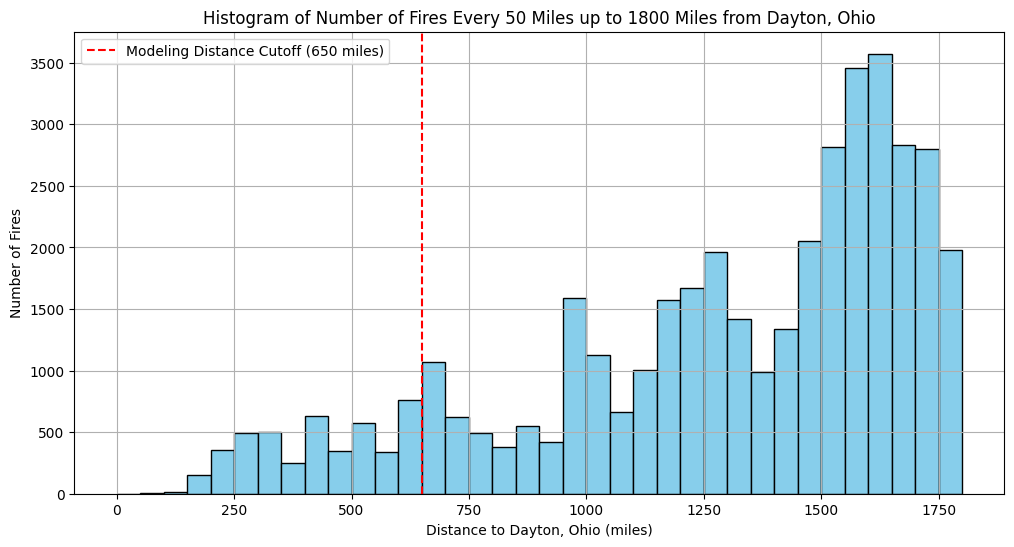

In [335]:
# set up bins 50 units long bins till 1800 
bins = range(0, 1850, 50)

# get ditances from fires dataframe 
fire_distances = fires["Distance"]

# plot histogram
plt.figure(figsize=(12, 6))
plt.hist(fire_distances, bins=bins, edgecolor='black', color = 'skyblue')

# line for distance used for analysis
plt.axvline(x=650, color='red', linestyle='--', label="Modeling Distance Cutoff (650 miles)")
plt.xlabel("Distance to Dayton, Ohio (miles)")
plt.ylabel("Number of Fires")
plt.title("Histogram of Number of Fires Every 50 Miles up to 1800 Miles from Dayton, Ohio")
plt.legend()
plt.grid()
plt.show()

## Graph 2: Time series graph of total acres burned per year for fires within 650 miles of Dayton, Ohio in the last 60 years. 

I calculated the total acres burned per year by iterating through my filtered batch of fires within 650 miles of Dayton, Ohio. I saved the the distance, year, and GIS acres data to a dataframe. I then aggregated number of acres burned each year by summing those values. There is a sharp spike in acres burned in 1991, where the acres burned reaches almost 3500. 

In [211]:
acres = []
for feature in filtered_batch_650:
    year = feature['attributes']['Fire_Year']
    distance = feature.get('distance', None)  # Include distance if needed
    gis_acres = feature['attributes'].get('GIS_Acres', 0)
    acres.append({'Year': year, 'Distance': distance, 'GIS_Acres': gis_acres})

# Create a DataFrame
acres_df = pd.DataFrame(acres)

# Group by year and sum the GIS acres
acres_df_final = acres_df.groupby('Year').agg({'GIS_Acres': 'mean'}).reset_index()

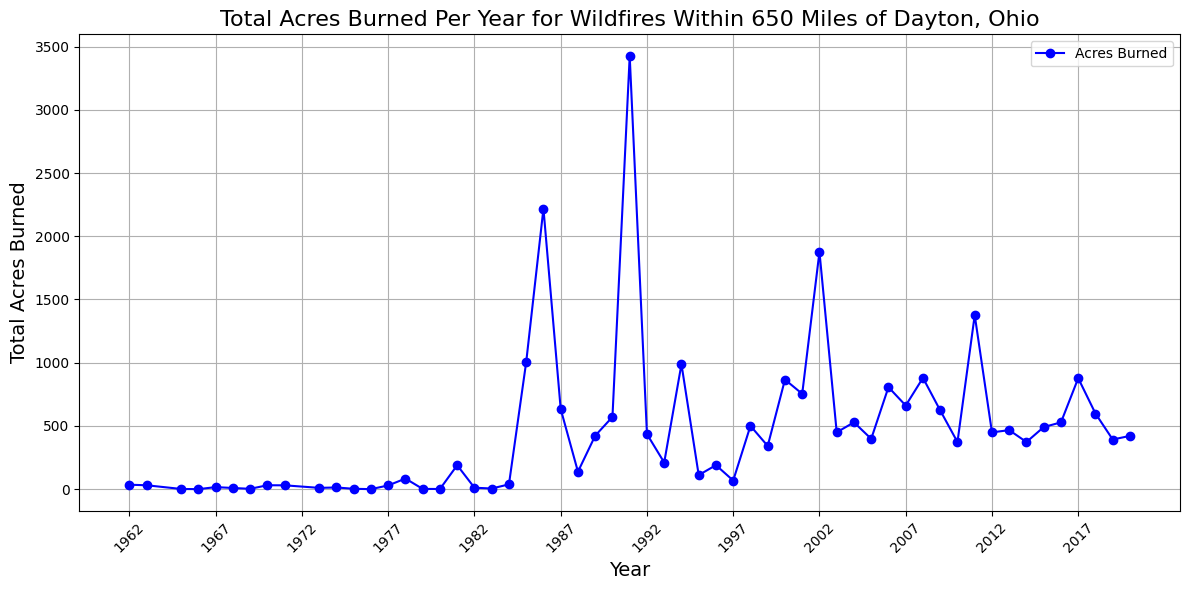

In [337]:
plt.figure(figsize=(12, 6))
plt.plot(acres_df_final['Year'], acres_df_final['GIS_Acres'], marker='o', color='b', label = 'Acres Burned')
plt.title('Total Acres Burned Per Year for Wildfires Within 650 Miles of Dayton, Ohio', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Total Acres Burned', fontsize=14)
#plt.xticks(acres_df_final['Year'], rotation=45)
plt.xticks(range(int(acres_df_final['Year'].min()), int(acres_df_final['Year'].max()) + 1, 5), rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## Graph 3: Time series graph containing fire smoke estimates and the AQI estimates for Dayton, Ohio.

Since my smoke estimates were very small (on the order of around 0.0001) and my AQI estimates were in the 10s, I decided to scale both those columns to be between 0 and 1. For example to scale a value x I followed the following equation: *(x - min) / (max - min)* to get my scaled value. Now with the scaled values we can see that the trend between smoke estimate and AQI follow each other pretty closely. We have to keep in mind there is no AQI data before 1985 which is why there is missing AQI data for that time on the graph. We can see a spike in both AQI and smoke estimate around 2004 and then both drop off around 2020, conveying the smoke estimate follows the AQI estimate decently. 


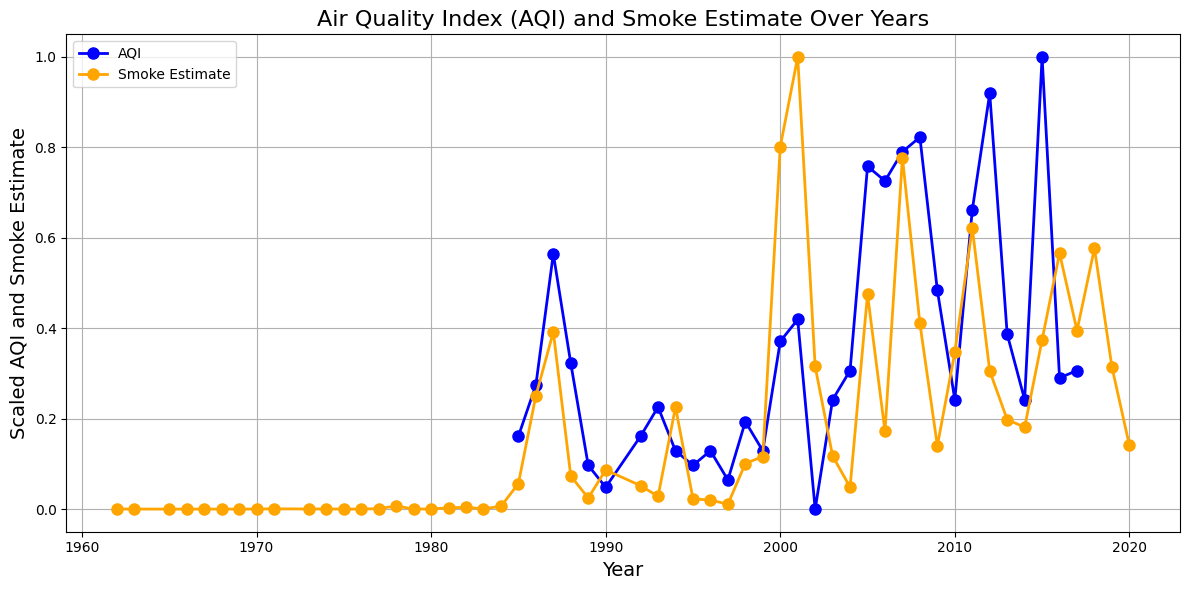

In [342]:
# convert year col to integer 
df_estimate.Year =df_estimate['Year'].astype(int)
df.Year =df['Year'].astype(int)
df_plt = pd.merge(df, df_estimate, how = 'right', on ='Year')

plt.figure(figsize=(12, 6))

# plot
plt.plot('Year', 'AQI_scaled', data=df_plt, marker='o', color='b', linestyle='-', linewidth=2, markersize=8, label = 'AQI')
plt.plot('Year', 'estimate_scaled', data=df_plt, marker='o', color='orange', linestyle='-', linewidth=2, markersize=8, label = 'Smoke Estimate')

# title and labels 
plt.title('Air Quality Index (AQI) and Smoke Estimate Over Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Scaled AQI and Smoke Estimate', fontsize=14)


plt.legend()
plt.grid(True)

# show 
plt.tight_layout()
plt.show()